# Stable Diffusion

Based on the the excellent tutorial [here](https://huggingface.co/blog/stable_diffusion).

Stable Diffusion consists of:

• a variational autoencoder which consists of
- an encoder which embeds an image into the latent space where diffusion happens and 
- a decoder which transforms the generated image in the latent space to an image we can parse

• a U-net used for removing noise on the generated images

• a text encoder (CLIP) which embeds text into the same space as images.

In this demo, we will be loading pretrained models of all of the above to visualize the process of diffusion. 

## Libraries

As always, we load a bunch of libraries. We'll need several custom packages for loading the pretrained models and visualizing the image sequence.

In [ ]:
! pip install --upgrade diffusers transformers scipy
! pip install accelerate
! pip install imageio==2.4.1

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from diffusers import LMSDiscreteScheduler
import torch
from tqdm.auto import tqdm
from PIL import Image
import moviepy.video.io.ImageSequenceClip
from moviepy.editor import *

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3162112/45929032 bytes (6.9%)5619712/45929032 bytes (12.2%)8536064/45929032 bytes (18.6%)11321344/45929032 bytes (24.6%)13598720/45929032 bytes (29.6%)16252928/45929032 bytes (35.4%)18636800/45929032 bytes (40.6%)22102016/45929032 bytes (48.1%)25706496/45929032 bytes (56.0%)28794880/45929032 bytes (62.7%)31227904/45929032 bytes (68.0%)33619968/45929032 bytes (73.2%)

## Pretrained Models

We'll need a huggingface account which will let us load the pretrained models. Note: it's very important that we load the weights with less memory; otherwise, we would overload the GPU.

In [ ]:
# https://huggingface.co/settings/tokens
YOUR_TOKEN = ''

# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_auth_token=YOUR_TOKEN, torch_dtype=torch.float16, revision="fp16")

# 2. Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_auth_token=YOUR_TOKEN, torch_dtype=torch.float16, revision="fp16")


Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


Downloading:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.0.layer_norm1.weight', 'vision_model.encoder.layers.4.layer_norm1.bias', 'vision_model.encoder.layers.13.mlp.fc2.bias', 'vision_model.encoder.layers.8.layer_norm2.bias', 'vision_model.encoder.layers.9.mlp.fc2.weight', 'vision_model.encoder.layers.11.self_attn.v_proj.bias', 'vision_model.encoder.layers.1.self_attn.out_proj.bias', 'vision_model.pre_layrnorm.bias', 'vision_model.encoder.layers.16.self_attn.q_proj.bias', 'vision_model.encoder.layers.23.mlp.fc1.weight', 'vision_model.encoder.layers.0.mlp.fc1.weight', 'vision_model.encoder.layers.13.layer_norm1.weight', 'vision_model.post_layernorm.bias', 'vision_model.encoder.layers.16.layer_norm1.bias', 'vision_model.encoder.layers.21.layer_norm1.bias', 'vision_model.encoder.layers.20.layer_norm2.weight', 'vision_model.encoder.layers.11.self_attn.out_proj.weight', 'vision_model.encoder.layers.13

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Now we'll specify the hyperparameters and, importantly, the prompt of the image we want generated.

In [ ]:
prompt = ["dancing heart"]

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion

num_inference_steps = 100           # Number of denoising steps

guidance_scale = 7.5                # Scale for classifier-free guidance

generator = torch.manual_seed(0)    # Seed generator to create the inital latent noise

batch_size = len(prompt)

We'll instantiate everything and move it to the GPU. These models are ginormous!!

In [ ]:
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler.set_timesteps(num_inference_steps)

torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device) 

def num_param(model, name):
  num_params = sum([p.numel() for p in model.parameters()])
  print(f'There are {num_params} in the {name}.')

num_param(vae, 'variational autoencoder')
num_param(text_encoder, 'text encoder')
num_param(unet, 'unet')

There are 83653863 in the variational autoencoder.
There are 123060480 in the text encoder.
There are 859520964 in the unet.


We'll generate the text embeddings which (for some reason?) consist of the conditional embeddings from the prompt and an unconditional embedding.

In [ ]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

cond_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_embeddings = torch.cat([uncond_embeddings, cond_embeddings]).to(torch.float16)

We start with random noise in the latent space which we'll scale.

In [ ]:
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
).to(torch.float16)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

Inference on a CPU takes almost an hour! Good thing we have access to a GPU :)

In [ ]:
all_latents = [latents]

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t).to(torch.float16)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample
    all_latents += [latents]

  0%|          | 0/100 [00:00<?, ?it/s]

Now we'll convert all these images into the image space we understand so we can visualize them.

In [ ]:
all_images = []
for latents in all_latents:
  latents = 1 / 0.18215 * latents
  image = vae.decode(latents).sample # latent to image space
  image = (image / 2 + 0.5).clamp(0, 1)
  image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
  image = (image * 255).round().astype("uint8")
  all_images += [image[0]]

Here, we make a small clip of the image generation process. So cool!

In [ ]:
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(all_images, fps=10)
ipython_display(clip)

100%|██████████| 101/101 [00:00<00:00, 132.24it/s]


The first image...

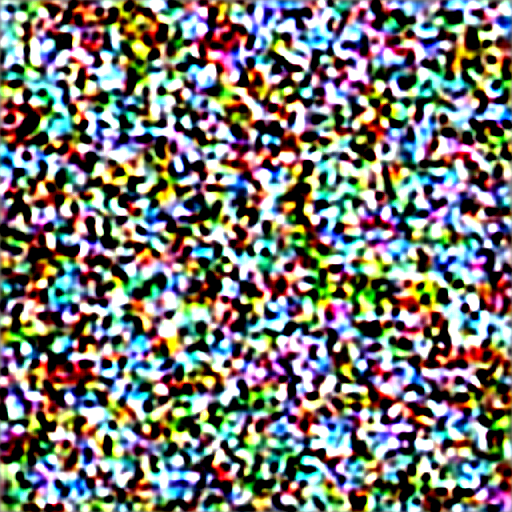

In [ ]:
Image.fromarray(all_images[0])

...and the last image.

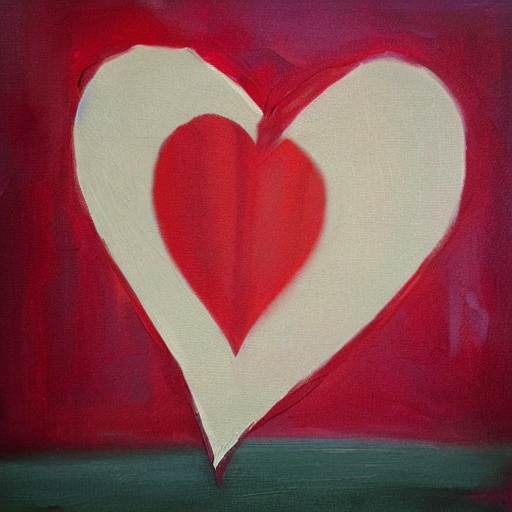

In [ ]:
Image.fromarray(all_images[-1])